## 00 configuration

In [1]:
!conda env list

# conda environments:
#
base                     /home/chirathv97/anaconda3
yolo3dpy37            *  /home/chirathv97/anaconda3/envs/yolo3dpy37



In [2]:
import sys
# sys.path.append("../")
import importlib
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import cython
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
import torchvision
from numba import jit
from tqdm import tqdm
import time

In [3]:
from visualDet3D.data.kitti.utils import write_result_to_file
from visualDet3D.utils.utils import LossLogger, cfg_from_file
from visualDet3D.networks.utils.registry import DETECTOR_DICT, DATASET_DICT, PIPELINE_DICT
from visualDet3D.networks.heads.anchors import Anchors
from visualDet3D.networks.lib.fast_utils.hill_climbing import post_opt
from visualDet3D.networks.utils import BBox3dProjector, BackProjection
from visualDet3D.utils.utils import convertAlpha2Rot, convertRot2Alpha, draw_3D_box, compound_annotation
import visualDet3D.data.kitti.dataset
from visualDet3D.utils.timer import Timer

In [4]:
print('CUDA available: {}'.format(torch.cuda.is_available()))

cfg = cfg_from_file("config/config.py")
is_test_train = True

checkpoint_name = "Stereo3D_latest.pth"

CUDA available: True


In [5]:
# Read Conifg File
cfg.batch_size=1
split_to_test='validation'

# Define dataset_name
is_test_train = split_to_test == 'training'
if split_to_test == 'training':
    dataset_name = cfg.data.train_dataset
elif split_to_test == 'test':
    dataset_name = cfg.data.test_dataset
else:
    dataset_name = cfg.data.val_dataset

# Make dataset
dataset = DATASET_DICT[dataset_name](
        cfg, split_to_test
        )

# Split train/validation data
if split_to_test=='training':
    dataset_val = DATASET_DICT[cfg.data.val_dataset](
            cfg, 'validation'
            )
    dataset.transform = dataset_val.transform
    dataset.collate_fn = dataset_val.collate_fn


In [6]:
# Build a detector network
detector = DETECTOR_DICT[cfg.detector.name](cfg.detector)
detector = detector.cuda()

# Tensor load by GPU
weight_path = os.path.join(cfg.path.checkpoint_path, checkpoint_name)
state_dict = torch.load(weight_path, map_location='cuda:{}'.format(cfg.trainer.gpu))
new_dict = state_dict.copy()
for key in state_dict:
    if 'focalLoss' in key:
        new_dict.pop(key)

# Load the pre-trained model
detector.load_state_dict(new_dict, strict=False)
detector.eval().cuda()

# Testing pipeline
test_func = PIPELINE_DICT[cfg.trainer.test_func]

# Load projector and backprojector
projector = BBox3dProjector().cuda()
backprojector = BackProjection().cuda()

## 01 YOLO3D objext detection and bounding box estimation

In [7]:
def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
    drawed_image = image.copy()
    for box2d in bboxes2d:
        cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
    return drawed_image

In [8]:
index = 0
def corner_homo2bbox(corner_homo):
    """
        corner_homo: [N, 8, 3]
    """
    min_xy  = torch.min(corner_homo[:, :, 0:2], dim=1)[0]
    max_xy  = torch.max(corner_homo[:, :, 0:2], dim=1)[0]
    min_xy[:, 0]  = torch.clamp(min_xy[:, 0], 0, cfg.rgb_shape[1])
    min_xy[:, 1]  = torch.clamp(min_xy[:, 1], 0, cfg.rgb_shape[0])
    max_xy[:, 0]  = torch.clamp(max_xy[:, 0], 0, cfg.rgb_shape[1])
    max_xy[:, 1]  = torch.clamp(max_xy[:, 1], 0, cfg.rgb_shape[0])
    return torch.cat([min_xy, max_xy], dim=1)

def denorm(image):
    new_image = np.array((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
    return new_image

@jit(cache=True, nopython=True)
def ToColorDepth(depth_image:np.ndarray)->np.ndarray: #[H, W] -> [H, W, 3] # Used to draw depth predictions
    H, W = depth_image.shape
    max_depth = float(np.max(depth_image))
    cmap = np.array([
        [0,0,0,114],[0,0,1,185],[1,0,0,114],[1,0,1,174], 
        [0,1,0,114],[0,1,1,185],[1,1,0,114],[1,1,1,0]
    ])
    _sum  = 0
    for i in range(8):
        _sum += cmap[i, 3]
    
    weights = np.zeros(8)
    cumsum = np.zeros(8)
    for i in range(7):
        weights[i] = _sum / cmap[i, 3]
        cumsum[i+1] = cumsum[i] + cmap[i, 3] / _sum
    
    image = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(H):
        for j in range(W):
            val = depth_image[i, j] / max_depth
            for k in range(7):
                if val <= cumsum[k + 1]:
                    break
            w = 1.0- (val - cumsum[k]) * weights[k]
            r = int( (w * cmap[k, 0] + (1 - w) * cmap[k+1, 0]) * 255 )
            g = int( (w * cmap[k, 1] + (1 - w) * cmap[k+1, 1]) * 255 )
            b = int( (w * cmap[k, 2] + (1 - w) * cmap[k+1, 2]) * 255 )
            image[i, j] = np.array([r,g,b])
    return image

In [9]:
def compute_once(index, is_draw=True, is_test_train=True):
    name = "%06d" % index
#     print(name)
    data = dataset[index]
    if isinstance(data['calib'], list):
        P2 = data['calib'][0]
    else:
        P2 = data['calib']
    original_height = data['original_shape'][0]
    collated_data = dataset.collate_fn([data])
    height = collated_data[0].shape[2]
    scale_2d = (original_height - cfg.data.augmentation.crop_top) / height
    
    if len(collated_data) > 6:
        left_images, right_images, _, _, labels, bbox_3d, _ = collated_data
    else:
        left_images, right_images, _, _, labels, bbox_3d = collated_data
    image = left_images

    with torch.no_grad():
        
        left_images, right_images, P2, P3 = collated_data[0], collated_data[1], collated_data[2], collated_data[3]
        scores, bbox, obj_names = detector([left_images.cuda().float().contiguous(),
                                          right_images.cuda().float().contiguous(),
                                          P2.cuda().float(),
                                          P3.cuda().float()])
        
        P2 = P2[0]
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())

            
    
    rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
    if len(scores) > 0:
        rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
    if is_draw:
        plt.imshow(np.clip(rgb_image, 0, 255))
        plt.show()

    return np.clip(rgb_image, 0, 255)

In [10]:
def compute_once_3d_bounding_box_only(index, is_draw=True, is_test_train=True):
    name = "%06d" % index
#     print(name)
    data = dataset[index]
    if isinstance(data['calib'], list):
        P2 = data['calib'][0]
    else:
        P2 = data['calib']
    original_height = data['original_shape'][0]
    collated_data = dataset.collate_fn([data])
    height = collated_data[0].shape[2]
    scale_2d = (original_height - cfg.data.augmentation.crop_top) / height
    
    if len(collated_data) > 6:
        left_images, right_images, _, _, labels, bbox_3d, _ = collated_data
    else:
        left_images, right_images, _, _, labels, bbox_3d = collated_data
    image = left_images

    with torch.no_grad():
        
        left_images, right_images, P2, P3 = collated_data[0], collated_data[1], collated_data[2], collated_data[3]
        scores, bbox, obj_names = detector([left_images.cuda().float().contiguous(),
                                          right_images.cuda().float().contiguous(),
                                          P2.cuda().float(),
                                          P3.cuda().float()])
        
        P2 = P2[0]
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())

            
    
    rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
    if len(scores) > 0:
        
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
    if is_draw:
        plt.imshow(np.clip(rgb_image, 0, 255))
        

    return np.clip(rgb_image, 0, 255)

In [11]:
def show_3d_boxes(index):
    fig = plt.figure(figsize=(16,9))
    a = compute_once_3d_bounding_box_only(index, is_test_train=False, is_draw=True)

### 2D + 3D bounding boxes

In [12]:
# #%matplotlib inline
# fig = plt.figure(figsize=(16,9))
# index = 2
# a = compute_once(index, is_test_train=False, is_draw=True)
# # print(index,cv2.imwrite(('data/2d3d %02d.png'%index), cv2.cvtColor(a, cv2.COLOR_RGB2BGR)))

### 3D bounding boxes Only

In [13]:
# show_3d_boxes(10)

## 02 Tracking

In [14]:
from IPython.display import clear_output

In [15]:
# pwd

In [16]:
def get_predictions(index):
    name = "%06d" % index
    data = dataset[index]
    if isinstance(data['calib'], list):
        P2 = data['calib'][0]
    else:
        P2 = data['calib']
    original_height = data['original_shape'][0]
    collated_data = dataset.collate_fn([data])
    height = collated_data[0].shape[2]
    scale_2d = (original_height - cfg.data.augmentation.crop_top) / height
    
    if len(collated_data) > 6:
        left_images, right_images, _, _, labels, bbox_3d, _ = collated_data
    else:
        left_images, right_images, _, _, labels, bbox_3d = collated_data
    image = left_images

    with torch.no_grad():
        
        left_images, right_images, P2, P3 = collated_data[0], collated_data[1], collated_data[2], collated_data[3]
        scores, bbox, obj_names = detector([left_images.cuda().float().contiguous(),
                                          right_images.cuda().float().contiguous(),
                                          P2.cuda().float(),
                                          P3.cuda().float()])
        
        P2 = P2[0]
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())
        
        rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
        
        return rgb_image, scores, bbox_2d, obj_names, bbox_3d_corner_homo
    
#     if len(scores) > 0:
#         rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
#         for box in bbox_3d_corner_homo:
#             box = box.cpu().numpy().T
#             rgb_image = draw_3D_box(rgb_image, box)
#     if is_draw:
#         plt.imshow(np.clip(rgb_image, 0, 255))
        
#     return np.clip(rgb_image, 0, 255)

In [17]:
"""
    SORT: A Simple, Online and Realtime Tracker
    Copyright (C) 2016-2020 Alex Bewley alex@bewley.ai

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""
from __future__ import print_function

import os
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.patches as patches
from skimage import io

import glob
import time
import argparse
from filterpy.kalman import KalmanFilter

np.random.seed(0)

In [18]:
def linear_assignment(cost_matrix):
  try:
    import lap
    _, x, y = lap.lapjv(cost_matrix, extend_cost=True)
    return np.array([[y[i],i] for i in x if i >= 0]) #
  except ImportError:
    from scipy.optimize import linear_sum_assignment
    x, y = linear_sum_assignment(cost_matrix)
    return np.array(list(zip(x, y)))


def iou_batch(bb_test, bb_gt):
  """
  From SORT: Computes IOU between two bboxes in the form [x1,y1,x2,y2]
  """
  bb_gt = np.expand_dims(bb_gt, 0)
  bb_test = np.expand_dims(bb_test, 1)
  
  xx1 = np.maximum(bb_test[..., 0], bb_gt[..., 0])
  yy1 = np.maximum(bb_test[..., 1], bb_gt[..., 1])
  xx2 = np.minimum(bb_test[..., 2], bb_gt[..., 2])
  yy2 = np.minimum(bb_test[..., 3], bb_gt[..., 3])
  w = np.maximum(0., xx2 - xx1)
  h = np.maximum(0., yy2 - yy1)
  wh = w * h
  o = wh / ((bb_test[..., 2] - bb_test[..., 0]) * (bb_test[..., 3] - bb_test[..., 1])                                      
    + (bb_gt[..., 2] - bb_gt[..., 0]) * (bb_gt[..., 3] - bb_gt[..., 1]) - wh)                                              
  return(o)  


def convert_bbox_to_z(bbox):
  """
  Takes a bounding box in the form [x1,y1,x2,y2] and returns z in the form
    [x,y,s,r] where x,y is the centre of the box and s is the scale/area and r is
    the aspect ratio
  """
  w = bbox[2] - bbox[0]
  h = bbox[3] - bbox[1]
  x = bbox[0] + w/2.
  y = bbox[1] + h/2.
  s = w * h    #scale is just area
  r = w / float(h)
  return np.array([x, y, s, r]).reshape((4, 1))


def convert_x_to_bbox(x,score=None):
  """
  Takes a bounding box in the centre form [x,y,s,r] and returns it in the form
    [x1,y1,x2,y2] where x1,y1 is the top left and x2,y2 is the bottom right
  """
  w = np.sqrt(x[2] * x[3])
  h = x[2] / w
  if(score==None):
    return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.]).reshape((1,4))
  else:
    return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.,score]).reshape((1,5))


In [19]:
class KalmanBoxTracker(object):
  """
  This class represents the internal state of individual tracked objects observed as bbox.
  """
  count = 0
  def __init__(self,bbox):
    """
    Initialises a tracker using initial bounding box.
    """
    #define constant velocity model
    self.kf = KalmanFilter(dim_x=7, dim_z=4) 
    self.kf.F = np.array([[1,0,0,0,1,0,0],[0,1,0,0,0,1,0],[0,0,1,0,0,0,1],[0,0,0,1,0,0,0],  [0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]])
    self.kf.H = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0]])

    self.kf.R[2:,2:] *= 10.
    self.kf.P[4:,4:] *= 1000. #give high uncertainty to the unobservable initial velocities
    self.kf.P *= 10.
    self.kf.Q[-1,-1] *= 0.01
    self.kf.Q[4:,4:] *= 0.01

    self.kf.x[:4] = convert_bbox_to_z(bbox)
    self.time_since_update = 0
    self.id = KalmanBoxTracker.count
    KalmanBoxTracker.count += 1
    self.history = []
    self.hits = 0
    self.hit_streak = 0
    self.age = 0

  def update(self,bbox):
    """
    Updates the state vector with observed bbox.
    """
    self.time_since_update = 0
    self.history = []
    self.hits += 1
    self.hit_streak += 1
    self.kf.update(convert_bbox_to_z(bbox))

  def predict(self):
    """
    Advances the state vector and returns the predicted bounding box estimate.
    """
    if((self.kf.x[6]+self.kf.x[2])<=0):
      self.kf.x[6] *= 0.0
    self.kf.predict()
    self.age += 1
    if(self.time_since_update>0):
      self.hit_streak = 0
    self.time_since_update += 1
    self.history.append(convert_x_to_bbox(self.kf.x))
    return self.history[-1]

  def get_state(self):
    """
    Returns the current bounding box estimate.
    """
    return convert_x_to_bbox(self.kf.x)



In [20]:
def associate_detections_to_trackers(detections,trackers,iou_threshold = 0.3):
  """
  Assigns detections to tracked object (both represented as bounding boxes)

  Returns 3 lists of matches, unmatched_detections and unmatched_trackers
  """
  if(len(trackers)==0):
    return np.empty((0,2),dtype=int), np.arange(len(detections)), np.empty((0,5),dtype=int)

  iou_matrix = iou_batch(detections, trackers)

  if min(iou_matrix.shape) > 0:
    a = (iou_matrix > iou_threshold).astype(np.int32)
    if a.sum(1).max() == 1 and a.sum(0).max() == 1:
        matched_indices = np.stack(np.where(a), axis=1)
    else:
      matched_indices = linear_assignment(-iou_matrix)
  else:
    matched_indices = np.empty(shape=(0,2))

  unmatched_detections = []
  for d, det in enumerate(detections):
    if(d not in matched_indices[:,0]):
      unmatched_detections.append(d)
  unmatched_trackers = []
  for t, trk in enumerate(trackers):
    if(t not in matched_indices[:,1]):
      unmatched_trackers.append(t)

  #filter out matched with low IOU
  matches = []
  for m in matched_indices:
    if(iou_matrix[m[0], m[1]]<iou_threshold):
      unmatched_detections.append(m[0])
      unmatched_trackers.append(m[1])
    else:
      matches.append(m.reshape(1,2))
  if(len(matches)==0):
    matches = np.empty((0,2),dtype=int)
  else:
    matches = np.concatenate(matches,axis=0)

  return matches, np.array(unmatched_detections), np.array(unmatched_trackers)


In [21]:
class Sort(object):
  def __init__(self, max_age=1, min_hits=3, iou_threshold=0.3):
    """
    Sets key parameters for SORT
    """
    self.max_age = max_age
    self.min_hits = min_hits
    self.iou_threshold = iou_threshold
    self.trackers = []
    self.frame_count = 0

  def update(self, dets=np.empty((0, 5))):
    """
    Params:
      dets - a numpy array of detections in the format [[x1,y1,x2,y2,score],[x1,y1,x2,y2,score],...]
    Requires: this method must be called once for each frame even with empty detections (use np.empty((0, 5)) for frames without detections).
    Returns the a similar array, where the last column is the object ID.

    NOTE: The number of objects returned may differ from the number of detections provided.
    """
    self.frame_count += 1
    # get predicted locations from existing trackers.
    trks = np.zeros((len(self.trackers), 5))
    to_del = []
    ret = []
    for t, trk in enumerate(trks):
      pos = self.trackers[t].predict()[0]
      trk[:] = [pos[0], pos[1], pos[2], pos[3], 0]
      if np.any(np.isnan(pos)):
        to_del.append(t)
    trks = np.ma.compress_rows(np.ma.masked_invalid(trks))
    for t in reversed(to_del):
      self.trackers.pop(t)
    matched, unmatched_dets, unmatched_trks = associate_detections_to_trackers(dets,trks, self.iou_threshold)

    # update matched trackers with assigned detections
    for m in matched:
      self.trackers[m[1]].update(dets[m[0], :])

    # create and initialise new trackers for unmatched detections
    for i in unmatched_dets:
        trk = KalmanBoxTracker(dets[i,:])
        self.trackers.append(trk)
    i = len(self.trackers)
    for trk in reversed(self.trackers):
        d = trk.get_state()[0]
        if (trk.time_since_update < 1) and (trk.hit_streak >= self.min_hits or self.frame_count <= self.min_hits):
          ret.append(np.concatenate((d,[trk.id+1])).reshape(1,-1)) # +1 as MOT benchmark requires positive
        i -= 1
        # remove dead tracklet
        if(trk.time_since_update > self.max_age):
          self.trackers.pop(i)
    if(len(ret)>0):
      return np.concatenate(ret)
    return np.empty((0,5))


In [22]:
#create instance of SORT
mot_tracker = Sort() 

In [23]:
def assignTrackID(index):
    # get detections
    rgb_image, scores, bbox_2d, obj_names, bbox_3d_corner_homo=get_predictions(index)
    
    if len(scores) > 0:
        
        detectionsList=[]
        for i in range(len(scores)):
            detection=np.append((bbox_2d[i]).cpu(),scores[i].cpu())
            detectionsList.append(detection)
        detectionsNumPyArray = np.asarray(detectionsList)
        # update SORT
        #  def update(self, dets=np.empty((0, 5))):
        """
            Params:
              dets - a numpy array of detections in the format [[x1,y1,x2,y2,score],[x1,y1,x2,y2,score],...]
            Requires: this method must be called once for each frame even with empty detections (use np.empty((0, 5)) for frames without detections).
            Returns the a similar array, where the last column is the object ID.

            NOTE: The number of objects returned may differ from the number of detections provided.
        """
        track_bbs_ids = mot_tracker.update(detectionsNumPyArray)
    # track_bbs_ids is a np array where each row contains a valid bounding box and track_id (last column)

        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)

        track_bbs_ids_list=track_bbs_ids.tolist()
        
        for j in range(len(track_bbs_ids_list)):
            coords = track_bbs_ids_list[j]
            x1,y1,x2,y2=int(coords[0]),int(coords[1]),int(coords[2]),int(coords[3])
            trackID=int(coords[4])
            name="ID: {}".format(str(trackID))

            # font
            font = cv2.FONT_HERSHEY_SIMPLEX
            # org
            org = (x1, y1-10)
            # fontScale
            fontScale = 0.9
            # Line thickness of 2 px
            thickness = 2
            # Blue color in BGR
            color=(0, 255, 255)
            text_color_bg=(0, 0, 0)
            text_size, _ = cv2.getTextSize(name, font, fontScale, thickness)
            text_w, text_h = text_size
            cv2.rectangle(rgb_image, (x1 , y1-10 - text_h), (x1 + text_w, y1-10), text_color_bg, -1)
            
            # Using cv2.putText() method
            cv2.putText(rgb_image,name, org, font, fontScale, color, thickness, cv2.LINE_AA)

                
# def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
#     drawed_image = image.copy()
#     for box2d in bboxes2d:
#         cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
#     return drawed_image
            
    return np.clip(rgb_image, 0, 255), track_bbs_ids

### 3D bounding boxes + Track ID

In [24]:
# fig = plt.figure(figsize=(16,9))
# index=0

# start = time.time()
# a,track_bbs_ids=assignTrackID(index)
# end = time.time()

# plt.imshow(a)
# plt.show()
# # Time elapsed
# seconds = end - start
# print ("Time taken : {0} seconds".format(seconds))

# # Calculate frames per second
# fps  = 1 / seconds
# print("Estimated frames per second : {0}".format(fps))

## 02 Trajectory Prediction

In [25]:
fig = plt.figure(figsize=(16,9))
index=0

image,track_bbs_ids=assignTrackID(index)
image_o=image.copy()

/home/chirathv97/FYP/visualDet3D/visualDet3D/data/kitti/dataset/stereo_dataset.py:155: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525553989/work/torch/csrc/utils/tensor_new.cpp:230.)
  return torch.from_numpy(left_images).float(), torch.from_numpy(right_images).float(), torch.tensor(P2).float(), torch.tensor(P3).float(), label, bbox2ds, bbox3ds


PSM Cos Volume takes 0.0017902851104736328 seconds at call time 1


/home/chirathv97/FYP/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/chirathv97/FYP/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


In [26]:
# fig = plt.figure(figsize=(16,9))
# plt.imshow(image)
# plt.show()

In [27]:
initial_bb=track_bbs_ids[-1,:-1]
# print(initial_bb)

In [28]:
ktp = KalmanBoxTracker(initial_bb)

In [29]:
def draw_next_trajectory(image,bb,i):
#     bb=bb.astype(int)
    xm=int((bb[0]+bb[2])/2)
    ym=int((bb[1]+bb[3])/2)
     # font
    font = cv2.FONT_HERSHEY_SIMPLEX
    # org
    org = int(xm),int(ym)
    # fontScale
    fontScale = 0.9
    # Line thickness of 2 px
    thickness = 2
    # Blue color in BGR
    color=(255, 0, 0)
    text_color_bg=(0, 0, 0)
#     text_size, _ = cv2.getTextSize(name, font, fontScale, thickness)
#     text_w, text_h = text_size
#     cv2.rectangle(rgb_image, (x1 , y1-10 - text_h), (x1 + text_w, y1-10), text_color_bg, -1)
            
    # Using cv2.putText() method
    name=str(i)
    cv2.putText(image,name, org, font, fontScale, color, thickness, cv2.LINE_AA)

In [28]:
# fig = plt.figure(figsize=(16,9))
# image_c=image.copy()
# plt.imshow(image_c)
# draw_next_trajectory(image_c,initial_bb,0)
# plt.show()

In [23]:
bb_list=[]
image_list=[]
track_list_all_objects=[]
for i in range (837):
    print(i)
    imagei,track_bbs_ids=assignTrackID(i)
    bb=track_bbs_ids[-1,:-1]
    bb_list.append(bb)
    track_list_all_objects.append(track_bbs_ids)
    image_list.append(imagei)
    

0


/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


PSM Cos Volume takes 0.023459911346435547 seconds at call time 2
PSM Cos Volume takes 0.009279966354370117 seconds at call time 3
Cost Volume takes 0.010479450225830078 seconds at call time 1
1
PSM Cos Volume takes 0.018886566162109375 seconds at call time 4
PSM Cos Volume takes 0.014621496200561523 seconds at call time 5
Cost Volume takes 0.008395195007324219 seconds at call time 2
2
PSM Cos Volume takes 0.0182647705078125 seconds at call time 6
PSM Cos Volume takes 0.009250164031982422 seconds at call time 7
Cost Volume takes 0.007323265075683594 seconds at call time 3
3
PSM Cos Volume takes 0.02092576026916504 seconds at call time 8
PSM Cos Volume takes 0.011241912841796875 seconds at call time 9
Cost Volume takes 0.007849454879760742 seconds at call time 4
4
PSM Cos Volume takes 0.01825428009033203 seconds at call time 10
PSM Cos Volume takes 0.009147405624389648 seconds at call time 11
Cost Volume takes 0.007317543029785156 seconds at call time 5
5
PSM Cos Volume takes 0.018230915

In [24]:
bb_list_copy=bb_list.copy()
image_list_copy=image_list.copy()
track_list_all_objects_copy=track_list_all_objects.copy()

In [3]:
import pandas as pd

In [25]:
# dictionary of lists  
dict = {'bb_list': bb_list, 'image_list': image_list, 'track_list_all_objects': track_list_all_objects}  
       
df = pd.DataFrame(dict) 
    
# saving the dataframe 
df.to_csv('images_with_tracking.csv') 

NameError: name 'pd' is not defined

In [ ]:
# read the dataframe 
df=pd.read_csv('images_with_tracking.csv') 

bb_list=df['bb_list']
image_list=df['image_list']
track_list_all_objects=df['track_list_all_objects']  

In [1]:
# bb_list

In [2]:
# image_list

In [29]:
track_list_all_objects

[array([[6.52697876e+02, 8.18961637e+01, 6.79823487e+02, 1.05297699e+02,
         7.00000000e+00],
        [2.97884339e+02, 8.13749544e+01, 4.01955383e+02, 1.40644150e+02,
         6.00000000e+00],
        [6.10144776e+02, 8.16984178e+01, 6.43229736e+02, 1.10369560e+02,
         5.00000000e+00],
        [1.14518862e-06, 9.50048530e+01, 2.15506530e+02, 2.23094695e+02,
         4.00000000e+00],
        [4.82245239e+02, 8.30200118e+01, 5.48613159e+02, 1.31762863e+02,
         3.00000000e+00],
        [7.10636781e+02, 9.18518761e+01, 8.31343444e+02, 1.94384704e+02,
         2.00000000e+00],
        [3.62534119e+02, 8.82979282e+01, 5.01755615e+02, 1.77123428e+02,
         1.00000000e+00]]),
 array([[652.90944281,  81.68290635, 680.32272412, 105.23531441,
           7.        ],
        [293.78096327,  81.33367831, 399.84998859, 141.30839936,
           6.        ],
        [610.01448945,  81.21420385, 642.61406229, 109.58571102,
           5.        ],
        [ -2.21127398,  96.73968625, 2

In [33]:
# bb_list_saved=[[692.4096873 ,  83.32576469, 763.98346397, 135.0803572 ],
#  [691.81421877,  83.6167289 , 763.05056484, 136.07131263],
#  [691.5050883 ,  83.55840326, 762.62165936, 136.3094644 ],
#  [691.05792471,  83.41331726, 762.25365657, 136.20346428],
#  [690.71082536,  83.29223695, 761.77100816, 136.08748713],
#  [690.89720186,  83.23456592, 762.05860953, 136.03581485],
#  [690.67949149,  83.11648409, 762.01686549, 135.81260878],
#  [690.67635627,  83.06941189, 762.27088863, 135.63069714],
#  [690.58490485,  82.90524512, 762.18728658, 135.3615848 ],
#  [690.55505677,  82.78152507, 762.08500008, 134.98401918],
#  [690.67132736,  82.69352507, 762.1828055 , 134.80414822],
#  [690.42393712,  82.8231493 , 761.88927733, 134.87368065],
#  [690.62669307,  83.005109  , 761.85377581, 135.04213458],
#  [690.74118848,  83.17900669, 761.74506807, 135.10095599],
#  [690.65556984,  83.17713975, 761.52943304, 134.99402932],
#  [690.45706986,  83.02642155, 761.06514421, 134.65676227],
#  [690.08712869,  82.82139043, 759.92469403, 134.0765081 ],
#  [689.87919732,  82.97912807, 758.83868433, 133.87316785],
#  [689.66248336,  82.65531639, 757.74704639, 133.08540318],
#  [689.69638784,  82.53336025, 756.88784659, 132.60748618],
#  [689.33437156,  82.47360251, 755.62710964, 132.25341072],
#  [689.05524596,  82.59750125, 754.63475047, 131.97200342],
#  [688.79578226,  82.74657588, 753.68192723, 131.66659305],
#  [688.67746629,  82.57713056, 753.04369616, 131.10890666],
#  [688.16450752,  82.50804333, 752.33712441, 130.76275417],
#  [687.91302451,  82.64346509, 751.74394857, 130.58160571],
#  [687.25138815,  82.35028698, 750.71776515, 129.94480332],
#  [686.65695754,  82.26836599, 749.79229301, 129.38687778],
#  [685.56618428,  82.52246515, 748.37341794, 129.25360775],
#  [684.82584163,  82.38370217, 746.89305958, 128.6975299 ],
#  [683.99307131,  82.14694155, 745.12251092, 127.86330358],
#  [683.14184441,  82.31159361, 743.51353566, 127.42897417],
#  [683.17884157,  82.29014919, 742.82709913, 126.96363228],
#  [682.6465723 ,  82.73561364, 741.55186618, 126.92129064],
#  [681.82399303,  83.23288559, 739.97212111, 126.9720279 ],
#  [681.21231321,  83.74218498, 738.41022176, 126.8774326 ],
#  [680.87531837,  83.9875739 , 737.03089999, 126.5622305 ],
#  [680.7207552 ,  84.34918536, 735.82259335, 126.43205274],
#  [680.51710579,  84.5732593 , 734.75832956, 126.22311953],
#  [680.67742428,  84.7246396 , 734.01635407, 125.90068668],
#  [680.73272985,  84.86300609, 733.19315595, 125.49480307],
#  [680.71273058,  85.09916893, 732.61289667, 125.24441856],
#  [680.40374645,  85.53936385, 731.73595696, 125.18381283],
#  [680.27209941,  85.94770252, 731.16242866, 125.20010774],
#  [680.1702006 ,  86.07841413, 730.75015954, 124.92244777],
#  [679.9678919 ,  86.20204695, 729.96391634, 124.6386028 ],
#  [679.53113463,  86.28862055, 729.10950979, 124.32777588],
#  [679.09622384,  86.66094516, 728.26776925, 124.22197444],
#  [678.72676948,  86.48949057, 727.26433854, 123.55195741],
#  [678.4769713 ,  86.54621289, 726.30977046, 123.20588031],
#  [678.17251353,  86.60085388, 725.28407746, 122.86350103],
#  [678.25688059,  86.61021641, 724.78346509, 122.5821465 ],
#  [677.82316116,  86.86534727, 723.91081797, 122.64001013],
#  [677.47035396,  86.97779496, 723.20542601, 122.40048365],
#  [677.2170934 ,  87.26940807, 722.60050491, 122.44933595],
#  [676.88228094,  87.46185291, 721.84705812, 122.24866663],
#  [676.36074226,  87.83675604, 720.98305308, 122.28486214],
#  [676.02086005,  87.91560317, 720.4432629 , 122.06251591],
#  [675.80495728,  87.4741554 , 719.96029465, 121.34737008],
#  [675.29989001,  87.09289645, 719.11149097, 120.65128009],
#  [674.88667068,  86.99118603, 718.3551252 , 120.31920445],
#  [674.42554747,  86.23192798, 717.57916302, 119.31614147],
#  [673.65973774,  84.59471527, 716.41798285, 117.42190087],
#  [673.33886157,  83.46788182, 715.64360791, 115.96966079],
#  [673.01251465,  82.15184126, 714.81748309, 114.37534872],
#  [673.05176346,  81.32514563, 714.6460938 , 113.29516927],
#  [672.67358457,  81.02402516, 714.12155462, 112.76665819],
#  [672.15963446,  80.98141946, 713.40049259, 112.44144907],
#  [671.71044504,  81.07245387, 712.86584114, 112.24340549],
#  [670.9499307 ,  80.7731648 , 711.99255718, 111.75560203],
#  [670.24346848,  80.25151323, 711.08581043, 110.99955986],
#  [669.82408886,  79.6951804 , 710.50194308, 110.2905899 ],
#  [669.4958366 ,  79.59219779, 709.78241358, 110.0408243 ],
#  [669.12275278,  79.30795627, 708.94149101, 109.62340761],
#  [668.94145073,  79.04715109, 708.26015396, 109.17080081],
#  [668.74822602,  79.01989271, 707.51478372, 108.92184631],
#  [667.82541597,  79.40840452, 706.12084553, 108.94189043],
#  [667.29506601,  79.69668749, 705.06545796, 108.79064991],
#  [667.10803741,  79.72347144, 704.40943092, 108.47438253],
#  [666.71656228,  80.33324151, 703.58505739, 108.76825419],
#  [666.43356558,  80.9725867 , 702.73757871, 109.08053053],
#  [666.05197417,  81.25645264, 702.08037852, 109.03626227],
#  [665.29448705,  81.70451241, 701.27061683, 109.25019043],
#  [664.50010782,  81.83203004, 700.37927834, 109.18670343],
#  [664.01145407,  81.81744898, 699.63424132, 108.98709217],
#  [663.42147915,  81.71162496, 698.88154659, 108.62926269],
#  [662.4780403 ,  81.86543504, 697.77924615, 108.4904378 ],
#  [661.55531243,  82.11712391, 696.40170007, 108.39704611],
#  [660.79955387,  82.49189177, 695.10366815, 108.32959036],
#  [660.27666771,  82.68622628, 694.06272519, 108.17358636],
#  [659.49182559,  82.77606853, 692.7796382 , 107.88990612],
#  [658.85271787,  82.4267966 , 691.5972877 , 107.18794515],
#  [658.02861484,  82.227788  , 690.31866174, 106.54396447],
#  [657.22679583,  82.26349032, 689.2412406 , 106.25415113],
#  [656.93918638,  82.30204675, 688.39295055, 105.95609382],
#  [656.68119852,  82.35995328, 687.59096205, 105.62719212],
#  [655.64217074,  82.44026167, 685.95387461, 105.49531818],
#  [654.69621588,  82.37180078, 684.25600921, 105.06641894]]

In [203]:
# bb_list

[array([355.97296879,  88.19248457, 498.51296217, 178.9370029 ]),
 array([350.17332254,  88.87319818, 495.58190022, 181.16511888]),
 array([344.41010475,  88.77793103, 493.69593347, 182.83919505]),
 array([339.97091083,  88.98270934, 492.30466031, 184.5002232 ]),
 array([335.84973685,  89.2700105 , 490.86897498, 186.25183419]),
 array([330.92249538,  89.48520204, 488.679942  , 188.04640126]),
 array([326.31226303,  89.51337091, 486.36223966, 189.31656452]),
 array([322.23047806,  89.42576602, 485.0912617 , 190.3589522 ]),
 array([318.55931348,  89.36713082, 483.73746729, 191.75504592]),
 array([315.34699662,  89.38463976, 482.72086032, 193.21131902]),
 array([312.39790851,  89.11783611, 482.14788127, 194.21639356]),
 array([309.40214454,  89.1939988 , 481.30574123, 195.41899699]),
 array([306.60693071,  89.5790204 , 480.73914775, 196.85032295]),
 array([303.78909717,  89.57701919, 479.7966149 , 197.76253539]),
 array([301.0287346 ,  89.54160115, 478.58872366, 198.69392273]),
 array([29

In [31]:
def draw_next_predicted_trajectory(image,bb,i):
#     bb=bb.astype(int)
    xm=int((bb[0]+bb[2])/2)
    ym=int((bb[1]+bb[3])/2)
     # font
    font = cv2.FONT_HERSHEY_SIMPLEX
    # org
    org = int(xm),int(ym)
    # fontScale
    fontScale = 0.9
    # Line thickness of 2 px
    thickness = 2
    # Blue color in BGR
    color=(0, 255, 0)
    text_color_bg=(0, 0, 0)
#     text_size, _ = cv2.getTextSize(name, font, fontScale, thickness)
#     text_w, text_h = text_size
#     cv2.rectangle(rgb_image, (x1 , y1-10 - text_h), (x1 + text_w, y1-10), text_color_bg, -1)
            
    # Using cv2.putText() method
    name=str(i)
    cv2.putText(image,name, org, font, fontScale, color, thickness, cv2.LINE_AA)

In [32]:
x0_danger_zone=400#300#400
x1_danger_zone=800#900#800
y0_danger_zone=300
y1_danger_zone=200#150#200
w_danger_zone=100#150#100

In [33]:
def draw_danger_zone(rgb_image):
    x0=x0_danger_zone
    x1=x1_danger_zone
    y0=y0_danger_zone
    y1=y1_danger_zone
    w=w_danger_zone
    thickness=3
    color=text_color_bg=(0, 125, 255)
    pts=np.array([[x0,y0],[x0+w,y1],[x1-w,y1],[x1,y0]],np.int32)
    isClosed=True
    cv2.polylines(rgb_image, [pts],isClosed, color, thickness)
#     cv2.rectangle(rgb_image, (x0 , y0), (x1, y1), text_color_bg, 0)

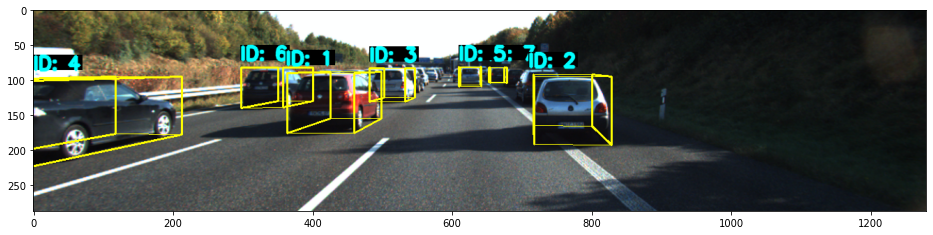

In [134]:
# # plt.imsave('trajectory.png')
# fig = plt.figure(figsize=(16,9))
# plt.imshow(image)
# plt.show()

In [34]:
fig = plt.figure(figsize=(16,9))
image_zone=image.copy()
draw_danger_zone(image_zone)
plt.imshow(image_zone)
plt.show()

In [199]:
# cv2.imwrite("danger_zone.png",cv2.cvtColor(image_zone, cv2.COLOR_RGB2BGR))

True

In [ ]:
i=1
for image in image_list.copy():
    fig = plt.figure(figsize=(16,9))
    clear_output(wait=True)
    draw_danger_zone(image)
    plt.imshow(image)
    plt.xlabel(i)
    cv2.imwrite("data/danger_zone %03d.png"%i,cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    i+=1
    plt.show()

In [35]:
## find current vehicles in danger zone
x0=x0_danger_zone #400
x1=x1_danger_zone #800
y0=y0_danger_zone #300
y1=y1_danger_zone #200
w=w_danger_zone #100

track_list=track_list_all_objects.copy()
bb_list_c=bb_list.copy()
image_list_c=image_list.copy()

NameError: name 'track_list_all_objects' is not defined

In [40]:
def is_in_zone(x,y):
    if x0<x<x1 and y0>y>y1:
        return True
    return False

In [41]:
def get_zone_check_point(bb):
    x0,y0,x1,y1=bb
    if x0<x1_danger_zone:
        x=x0
    else:
        x=x1
    y=max(y0,y1)
    return x,y

In [84]:
# get_zone_check_point(track_list[0][-1][:-1])

(717.6560478948551, 177.48744849164467)

In [38]:
for frame,track in enumerate(track_list):
    print('frame',frame)
    for vehicle in track:
        i=int(vehicle[-1])
        bb=vehicle[:-1]
        x,y=get_zone_check_point(bb)
        if is_in_zone(x,y):
            print('Warning!','Frame:',frame,'vehicle ID:',i)

frame 0
Warning! Frame: 0 vehicle ID: 2
Warning! Frame: 0 vehicle ID: 1
frame 1
Warning! Frame: 1 vehicle ID: 2
Warning! Frame: 1 vehicle ID: 1
frame 2
Warning! Frame: 2 vehicle ID: 2
Warning! Frame: 2 vehicle ID: 1
frame 3
Warning! Frame: 3 vehicle ID: 2
Warning! Frame: 3 vehicle ID: 1
frame 4
Warning! Frame: 4 vehicle ID: 2
Warning! Frame: 4 vehicle ID: 1
frame 5
Warning! Frame: 5 vehicle ID: 2
Warning! Frame: 5 vehicle ID: 1
frame 6
Warning! Frame: 6 vehicle ID: 2
Warning! Frame: 6 vehicle ID: 1
frame 7
Warning! Frame: 7 vehicle ID: 2
Warning! Frame: 7 vehicle ID: 1
frame 8
Warning! Frame: 8 vehicle ID: 2
Warning! Frame: 8 vehicle ID: 1
frame 9
Warning! Frame: 9 vehicle ID: 2
Warning! Frame: 9 vehicle ID: 1
frame 10
Warning! Frame: 10 vehicle ID: 2
Warning! Frame: 10 vehicle ID: 1
frame 11
Warning! Frame: 11 vehicle ID: 2
Warning! Frame: 11 vehicle ID: 1
frame 12
Warning! Frame: 12 vehicle ID: 2
Warning! Frame: 12 vehicle ID: 1
frame 13
Warning! Frame: 13 vehicle ID: 2
Warning! Fram

Warning! Frame: 568 vehicle ID: 128
Warning! Frame: 568 vehicle ID: 44
frame 569
Warning! Frame: 569 vehicle ID: 128
Warning! Frame: 569 vehicle ID: 44
frame 570
Warning! Frame: 570 vehicle ID: 44
frame 571
Warning! Frame: 571 vehicle ID: 44
frame 572
Warning! Frame: 572 vehicle ID: 44
frame 573
Warning! Frame: 573 vehicle ID: 44
frame 574
Warning! Frame: 574 vehicle ID: 44
frame 575
Warning! Frame: 575 vehicle ID: 130
Warning! Frame: 575 vehicle ID: 44
frame 576
Warning! Frame: 576 vehicle ID: 130
Warning! Frame: 576 vehicle ID: 44
frame 577
Warning! Frame: 577 vehicle ID: 130
Warning! Frame: 577 vehicle ID: 44
frame 578
Warning! Frame: 578 vehicle ID: 130
Warning! Frame: 578 vehicle ID: 44
frame 579
Warning! Frame: 579 vehicle ID: 130
Warning! Frame: 579 vehicle ID: 44
frame 580
Warning! Frame: 580 vehicle ID: 130
Warning! Frame: 580 vehicle ID: 44
frame 581
Warning! Frame: 581 vehicle ID: 130
Warning! Frame: 581 vehicle ID: 44
frame 582
Warning! Frame: 582 vehicle ID: 44
frame 583
W

In [43]:
def show_zone_warning(image_c,id_list):
#     fig = plt.figure(figsize=(16,9))
#     clear_output(wait=True)
#     draw_danger_zone(image_c)

    message= "Warning! ID:"+ str(id_list)

    font = cv2.FONT_HERSHEY_SIMPLEX
    org = 480,30
    fontScale = 1
    thickness = 1
    color=(255,0,0)

    cv2.putText(image_c,message, org, font, fontScale, color, thickness, cv2.LINE_AA)
#     plt.imshow(image_c)
#     plt.show()

In [44]:
no=588
ind=44
image_check=image_list_c[no].copy()
draw_danger_zone(image_check)
show_zone_warning(image_check,ind)

In [45]:
for frame,track in enumerate(track_list):
    id_list=[]
    print('frame',frame)
    for vehicle in track:
        vehicle_ID=int(vehicle[-1])
        bb=vehicle[:-1]
        x,y=get_zone_check_point(bb)
        if is_in_zone(x,y):
            print('Warning!','Frame:',frame,'vehicle ID:',vehicle_ID)
            id_list.append(vehicle_ID)
            
    image=image_list_c[frame].copy()
    draw_danger_zone(image)
    if len(id_list)>0:
            show_zone_warning(image,id_list)
    cv2.imwrite("data/collision_warning %03d.png"%frame,cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

frame 0
frame 1
frame 2
frame 3
frame 4
frame 5
frame 6
frame 7
frame 8
frame 9
frame 10
frame 11
frame 12
frame 13
frame 14
frame 15
frame 16
frame 17
frame 18
frame 19
frame 20
frame 21
frame 22
frame 23
frame 24
frame 25
frame 26
frame 27
frame 28
frame 29
frame 30
frame 31
frame 32
frame 33
frame 34
frame 35
frame 36
frame 37
frame 38
frame 39
frame 40
frame 41
frame 42
frame 43
frame 44
frame 45
frame 46
frame 47
frame 48
frame 49
frame 50
frame 51
frame 52
frame 53
frame 54
frame 55
frame 56
frame 57
frame 58
frame 59
frame 60
frame 61
frame 62
frame 63
frame 64
frame 65
frame 66
frame 67
frame 68
frame 69
frame 70
frame 71
frame 72
frame 73
frame 74
frame 75
frame 76
frame 77
frame 78
frame 79
frame 80
frame 81
frame 82
frame 83
frame 84
frame 85
frame 86
frame 87
frame 88
frame 89
frame 90
frame 91
frame 92
frame 93
frame 94
frame 95
frame 96
frame 97
frame 98
frame 99
frame 100
frame 101
frame 102
frame 103
frame 104
frame 105
frame 106
frame 107
frame 108
frame 109
frame 110


frame 787
Warning! Frame: 787 vehicle ID: 154
frame 788
Warning! Frame: 788 vehicle ID: 154
frame 789
Warning! Frame: 789 vehicle ID: 154
frame 790
Warning! Frame: 790 vehicle ID: 154
frame 791
Warning! Frame: 791 vehicle ID: 154
frame 792
Warning! Frame: 792 vehicle ID: 154
frame 793
Warning! Frame: 793 vehicle ID: 154
frame 794
Warning! Frame: 794 vehicle ID: 154
frame 795
Warning! Frame: 795 vehicle ID: 154
frame 796
Warning! Frame: 796 vehicle ID: 154
frame 797
Warning! Frame: 797 vehicle ID: 154
frame 798
Warning! Frame: 798 vehicle ID: 154
frame 799
Warning! Frame: 799 vehicle ID: 154
frame 800
Warning! Frame: 800 vehicle ID: 154
frame 801
Warning! Frame: 801 vehicle ID: 154
frame 802
Warning! Frame: 802 vehicle ID: 154
frame 803
Warning! Frame: 803 vehicle ID: 154
frame 804
Warning! Frame: 804 vehicle ID: 154
frame 805
Warning! Frame: 805 vehicle ID: 154
frame 806
Warning! Frame: 806 vehicle ID: 154
frame 807
Warning! Frame: 807 vehicle ID: 154
frame 808
Warning! Frame: 808 vehi

In [61]:
# for track in track_list[0]:
#     i=int(track[-1])
#     bb=track[:-1]
#     print(i,bb)

18 [480.76486899  83.26005588 545.38538359 130.15815121]
15 [611.54371387  81.816308   642.01626261 109.227424  ]
14 [ -3.6306007   92.4147996  186.26102004 234.35305526]
3 [367.71535873  89.39807811 500.15876835 174.33019197]
2 [717.65604789  96.52665766 829.0827191  177.48744849]


In [ ]:
## warning for current vehicles in danger zone

In [ ]:
## predict trajectory of vehicles

In [ ]:
## find trajectory of vehicles in danger zone

In [ ]:
## warning for trajectory of vehicles in danger zone

In [204]:
image_c=image.copy()

In [205]:
i=1
bb = bb_list_saved[i]
ktp.update(bb)
draw_next_trajectory(image_c,bb,i+1)

In [1]:
for i,bb in enumerate(bb_list_saved):
    fig = plt.figure(figsize=(16,9))
    ktp.update(bb)
    clear_output(wait=True)
    draw_next_trajectory(image_c,bb,i)
    plt.xlabel(i)
    plt.imshow(image_c)
    plt.show()
    

In [110]:
image_d=image_c.copy()

In [111]:
j=1
bb=ktp.predict()[0]
draw_next_predicted_trajectory(image_c,bb,a)

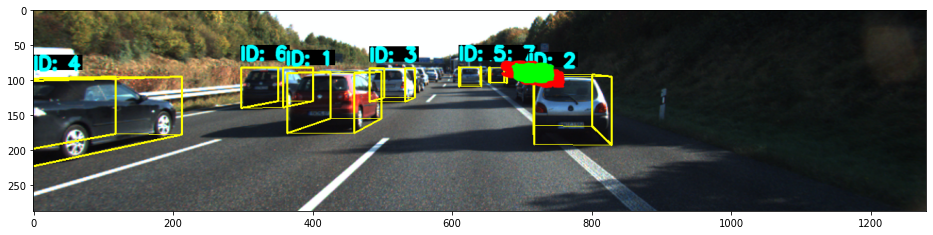

In [113]:
fig = plt.figure(figsize=(16,9))
plt.imshow(image_c)

In [112]:
for j in range(200):
    
    
    fig = plt.figure(figsize=(16,9))
    bb=ktp.predict()[0]
    draw_next_predicted_trajectory(image_c,bb,j)
    clear_output(wait=True)
    plt.xlabel(i)
    plt.imshow(image_c)
    plt.show()

In [151]:
imaged=image.copy()
font = cv2.FONT_HERSHEY_SIMPLEX
# org
org = int(xm),int(ym)
# fontScale
fontScale = 0.1
# Line thickness of 2 px
thickness = 1
# Blue color in BGR
color=(0, 255, 0)
text_color_bg=(0, 0, 0)
#     text_size, _ = cv2.getTextSize(name, font, fontScale, thickness)
#     text_w, text_h = text_size
#     cv2.rectangle(rgb_image, (x1 , y1-10 - text_h), (x1 + text_w, y1-10), text_color_bg, -1)

# Using cv2.putText() method
name=str(2)
cv2.putText(imaged,name, org, font, fontScale, color, thickness, cv2.LINE_AA)
plt.imshow(imaged)
plt.show()

## 03 saving results

In [ ]:
import time

def get_frame_rate():
    # Start time
    start = time.time()

    # Grab a few frames
    for i in range(0, num_frames) :
        ret, frame = video.read()

    # End time
    end = time.time()

    # Time elapsed
    seconds = end - start
    print ("Time taken : {0} seconds".format(seconds))

    # Calculate frames per second
    fps  = num_frames / seconds
    print("Estimated frames per second : {0}".format(fps))

### 2D + 3D bounding boxes

In [30]:
start_2d3d = time.time()

for index in range(0,837):
#     fig = plt.figure(figsize=(16,9))
    a = compute_once(index, is_test_train=False, is_draw=False)
#     clear_output(wait=True)
#     plt.imshow(a)
    print(index,cv2.imwrite(('data/2d3d %03d.png'%index), cv2.cvtColor(a, cv2.COLOR_RGB2BGR)))
#     plt.xlabel(index)
#     plt.show()
         
end_2d3d = time.time()
# Time elapsed
seconds_2d3d  = end_2d3d  - start_2d3d 
print ("Time taken : {0} seconds".format(seconds_2d3d))

# Calculate frames per second
fps_2d3d  = 837 / seconds_2d3d
print("Estimated frames per second : {0}".format(fps_2d3d))

/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 True
15 True
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True
28 True
29 True
30 True
31 True
32 True
33 True
34 True
35 True
36 True
37 True
38 True
39 True
40 True
41 True
42 True
43 True
44 True
45 True
46 True
47 True
48 True
49 True
50 True
51 True
52 True
53 True
54 True
55 True
56 True
57 True
58 True
59 True
60 True
61 True
62 True
63 True
64 True
65 True
66 True
67 True
68 True
69 True
70 True
71 True
72 True
73 True
74 True
75 True
76 True
77 True
78 True
79 True
80 True
81 True
82 True
83 True
84 True
85 True
86 True
87 True
88 True
89 True
90 True
91 True
92 True
93 True
94 True
95 True
96 True
97 True
98 True
99 True
100 True
101 True
102 True
103 True
104 True
105 True
106 True
107 True
108 True
109 True
110 True
111 True
112 True
113 True
114 True
115 True
116 True
117 True
118 True
119 True
120 True
121 True
122 True
123

NameError: name 'seconds' is not defined

### 3D bounding boxes Only

In [39]:
start_3d = time.time()
for index in range(0,837):
#     fig = plt.figure(figsize=(16,9))
    a = compute_once_3d_bounding_box_only(index, is_test_train=False, is_draw=False)
#     clear_output(wait=True)
#     plt.imshow(a)
#     print(index,cv2.imwrite(('data/3d %03d.png'%index), cv2.cvtColor(a, cv2.COLOR_RGB2BGR)))
#     plt.xlabel(index)
#     plt.show()
         
end_3d = time.time()
# Time elapsed
seconds_3d = end_3d - start_3d
print ("Time taken : {0} seconds".format(seconds_3d))

# Calculate frames per second
fps_3d  = 837 / seconds_3d
print("Estimated frames per second : {0}".format(fps_3d))

/home/chirathv97/FYP/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/chirathv97/FYP/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


Time taken : 104.29294514656067 seconds
Estimated frames per second : 8.02547093500698


In [38]:
print(start_3d)
print(end_3d)
print(seconds_3d)
print(fps_3d)

1684411991.236658
1684412114.617281
123.38062286376953
6.783885350653254


hdd laptop
1680770171.802954
1680771943.199522
1771.3965680599213
0.4725085365366287

### 3D bounding boxes + Track ID

In [2]:
start_track = time.time()

for index in range(0,5):
    fig = plt.figure(figsize=(16,9))
    a = assignTrackID(index)
    clear_output(wait=True)
    plt.imshow(a)
    plt.xlabel(index)
    plt.show()
#     print(index,cv2.imwrite(('data/track %03d.png'%index), cv2.cvtColor(a, cv2.COLOR_RGB2BGR)))
end_track = time.time()


# Time elapsed
seconds_track = end_track - start_track
print ("Time taken : {0} seconds".format(seconds_track))

# Calculate frames per second
fps_track  = 837 / seconds_track
print("Estimated frames per second : {0}".format(fps_track))

hdd laptop
Time taken : 47.59913086891174 seconds
Estimated frames per second : 17.584354687170705

In [ ]:
print(start_track)
print(end_track)
print(seconds_track)
print(fps_track)